In [4]:
!pip install gymnasium "stable-baselines3[extra]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 4.4 MB/s eta 0:00:00


# LineWorld

Intuition first (no code)

Imagine a straight line of cells:

[A][ ][ ][ ][ ][G]


A = agent

G = goal

The agent can only:

move left

move right

That’s it. No physics, no randomness, no enemies.

What LineWorld is formally

LineWorld is usually defined by:

State (observation)

“Where am I on the line?”

Represented as a single integer

Example: position 0 … n-1

That’s why we used:

observation_space = spaces.Discrete(n)

Actions

“Which direction do I move?”

Usually:

0 → move left

1 → move right

So:

action_space = spaces.Discrete(2)

Transition dynamics

“What happens when I take an action?”

Example rules:

If at position i:

action 0 → max(0, i-1)

action 1 → min(n-1, i+1)

Very predictable. No randomness.

Reward

“Did I do something good?”

Typical choices:

+1 for reaching the goal

Small negative reward each step (-0.01) to encourage speed

Episode termination

The episode ends when:

The agent reaches the goal (terminated=True)

OR a step limit is reached (truncated=True)

In [2]:
# lineworld_env.py
import gymnasium as gym
from gymnasium import spaces

class LineWorldEnv(gym.Env):
    def __init__(self, n=10, max_steps=50, render_mode=None):
        super().__init__()
        self.n = int(n)
        self.max_steps = int(max_steps)
        self.render_mode = render_mode

        self.observation_space = spaces.Discrete(self.n)  # obs: integer 0..n-1
        self.action_space = spaces.Discrete(2)            # action: 0 or 1

        self.pos = None
        self.steps = 0

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.pos = 0
        self.steps = 0
        obs = self.pos
        info = {"pos": self.pos, "steps": self.steps}
        if self.render_mode == "human":
            self.render()
        return obs, info

    def step(self, action):
        self.steps += 1

        if action == 0:
            self.pos = max(0, self.pos - 1)
        elif action == 1:
            self.pos = min(self.n - 1, self.pos + 1)
        else:
            raise ValueError(f"Invalid action {action}")

        terminated = (self.pos == self.n - 1)
        truncated = (self.steps >= self.max_steps)
        reward = 1.0 if terminated else -0.01

        obs = self.pos
        info = {"pos": self.pos, "steps": self.steps}

        if self.render_mode == "human":
            self.render()

        return obs, reward, terminated, truncated, info

    def render(self):
        line = ["-"] * self.n
        line[self.pos] = "A"
        # mark goal
        if self.pos != self.n - 1:
            line[-1] = "G"
        print("".join(line), f" step={self.steps}")

    def close(self):
        pass

In [14]:


def describe_spaces(env):
    print("\n=== SPACES ===")
    print("Observation space:", env.observation_space)
    print("  sample obs:", env.observation_space.sample())
    print("Action space:", env.action_space)
    print("  sample action:", env.action_space.sample())
    print("================\n")

env = LineWorldEnv(n=8, max_steps=15, render_mode="human")
describe_spaces(env)


=== SPACES ===
Observation space: Discrete(8)
  sample obs: 6
Action space: Discrete(2)
  sample action: 0



In [15]:
obs, info = env.reset(seed=123)
print("RESET -> obs:", obs, "info:", info)
print("obs valid?", env.observation_space.contains(obs))
print()

while True:
    raw = input("action (0=left, 1=right, r=random, q=quit)> ").strip().lower()
    if raw == "q":
        break
    if raw == "r":
        action = env.action_space.sample()
        print("random action:", action)
    elif raw in ("0", "1"):
        action = int(raw)
    else:
        print("Enter 0, 1, r, or q.")
        continue

    # validate action against the declared space
    print("action valid?", env.action_space.contains(action))

    next_obs, reward, terminated, truncated, info = env.step(action)

    print("STEP ->")
    print("  obs:", next_obs, "valid?", env.observation_space.contains(next_obs))
    print("  reward:", reward)
    print("  terminated:", terminated, "truncated:", truncated)
    print("  info:", info)
    print()

    if terminated or truncated:
        print("Episode ended. Resetting...\n")
        obs, info = env.reset()
        print("RESET -> obs:", obs, "info:", info)
        print()

env.close()

A------G  step=0
RESET -> obs: 0 info: {'pos': 0, 'steps': 0}
obs valid? True

action (0=left, 1=right, r=random, q=quit)> 1
action valid? True
-A-----G  step=1
STEP ->
  obs: 1 valid? True
  reward: -0.01
  terminated: False truncated: False
  info: {'pos': 1, 'steps': 1}

action (0=left, 1=right, r=random, q=quit)> 1
action valid? True
--A----G  step=2
STEP ->
  obs: 2 valid? True
  reward: -0.01
  terminated: False truncated: False
  info: {'pos': 2, 'steps': 2}

action (0=left, 1=right, r=random, q=quit)> 1
action valid? True
---A---G  step=3
STEP ->
  obs: 3 valid? True
  reward: -0.01
  terminated: False truncated: False
  info: {'pos': 3, 'steps': 3}

action (0=left, 1=right, r=random, q=quit)> 
Enter 0, 1, r, or q.
action (0=left, 1=right, r=random, q=quit)> 
Enter 0, 1, r, or q.
action (0=left, 1=right, r=random, q=quit)> 1
action valid? True
----A--G  step=4
STEP ->
  obs: 4 valid? True
  reward: -0.01
  terminated: False truncated: False
  info: {'pos': 4, 'steps': 4}

actio

# Time Series Gym

In [16]:
!pip install gymnasium stable-baselines3 sb3-contrib pandas numpy yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 4.2 MB/s eta 0:00:00


In [17]:
# get_data.py
import yfinance as yf

df = yf.download("SPY", start="2015-01-01", progress=False)
df.to_csv("spy.csv")
print(df.tail())

/tmp/ipython-input-2115288023.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SPY", start="2015-01-01", progress=False)


Price            Close        High         Low        Open     Volume
Ticker             SPY         SPY         SPY         SPY        SPY
Date                                                                 
2025-12-11  689.169983  689.250000  682.169983  685.140015   86173700
2025-12-12  681.760010  688.880005  679.169983  688.169983  113160300
2025-12-15  680.729980  685.760010  679.250000  685.739990   90811000
2025-12-16  678.869995  681.080017  674.979980  679.229980  122030600
2025-12-17  671.400024  680.440002  671.200012  679.890015  109356100


In [18]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces

class PredictNextReturnEnv(gym.Env):
    """
    Time-series prediction env.
    Obs: last `window` returns (float32 vector)
    Act: predicted next return (float)
    Reward: negative squared error (0 is perfect; more negative is worse)
    """
    def __init__(self, close_prices: np.ndarray, window: int = 20, episode_len: int = 200):
        super().__init__()
        close_prices = np.asarray(close_prices, dtype=np.float64)
        if close_prices.ndim != 1 or len(close_prices) < window + 2:
            raise ValueError("close_prices must be 1D and long enough for the chosen window.")

        self.window = int(window)
        self.episode_len = int(episode_len)

        # log returns are common; simple returns are also fine
        self.returns = np.diff(np.log(close_prices)).astype(np.float32)  # length = len(prices)-1

        # Observation: last window returns
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.window,), dtype=np.float32
        )
        # Action: predicted next return (continuous)
        self.action_space = spaces.Box(
            low=-0.2, high=0.2, shape=(1,), dtype=np.float32
        )

        self._t = None
        self._steps = None

    def _get_obs(self):
        return self.returns[self._t - self.window : self._t].copy()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        # choose random start where we have enough history and enough room
        start_min = self.window
        start_max = len(self.returns) - 1  # must have a next return target
        self._t = int(self.np_random.integers(start_min, start_max))
        self._steps = 0

        obs = self._get_obs()
        info = {"target_return": float(self.returns[self._t])}
        return obs, info

    def step(self, action):
        action = np.asarray(action, dtype=np.float32).reshape(1,)
        pred = float(action[0])
        true = float(self.returns[self._t])

        err = pred - true
        reward = -(err * err)  # negative MSE

        self._t += 1
        self._steps += 1

        terminated = False
        truncated = (self._steps >= self.episode_len) or (self._t >= len(self.returns))

        obs = self._get_obs() if not truncated else np.zeros((self.window,), dtype=np.float32)
        info = {
            "pred_return": pred,
            "true_return": true,
            "error": err,
            "squared_error": err * err,
        }
        return obs, reward, terminated, truncated, info

In [23]:
.import pandas as pd
import numpy as np

# df = pd.read_csv("spy.csv")
# close = df["Close"].astype(float).to_numpy()

import pandas as pd

df = pd.read_csv("spy.csv")

# Parse dates; invalid rows become NaT and get dropped
df["Price"] = pd.to_datetime(df["Price"], errors="coerce")
df = df.dropna(subset=["Price"])

# Convert numeric columns
for c in ["Close", "High", "Low", "Open", "Volume"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["Close", "High", "Low", "Open", "Volume"])

close = df["Close"].to_numpy(dtype="float64")
# print(df.head())


env = PredictNextReturnEnv(close, window=10, episode_len=20)

obs, info = env.reset(seed=0)

def short(v):
    # print last few values of the observation window
    return np.round(v[-5:], 5)

print("RESET")
print("  obs(last5 returns):", short(obs))
print("  target_return:", round(info["target_return"], 6))
print()

for i in range(20):
    raw = input("predicted next return (e.g. 0.001), or r=random, q=quit> ").strip().lower()
    if raw == "q":
        break
    if raw == "r":
        action = env.action_space.sample()
        print("  random pred:", float(action[0]))
    else:
        action = np.array([float(raw)], dtype=np.float32)

    next_obs, reward, terminated, truncated, info = env.step(action)

    print(f"STEP {i:02d}")
    print("  obs(last5 returns):", short(obs))
    print("  pred_return:", round(info["pred_return"], 6))
    print("  true_return:", round(info["true_return"], 6))
    print("  error:", round(info["error"], 6))
    print("  reward (neg MSE):", round(reward, 8))
    print()

    obs = next_obs
    if terminated or truncated:
        print("Episode done.")
        break

env.close()

/tmp/ipython-input-3476038367.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Price"] = pd.to_datetime(df["Price"], errors="coerce")


RESET
  obs(last5 returns): [ 0.00917  0.0118  -0.00047 -0.00381  0.00943]
  target_return: 0.003535

predicted next return (e.g. 0.001), or r=random, q=quit> 0.001
STEP 00
  obs(last5 returns): [ 0.00917  0.0118  -0.00047 -0.00381  0.00943]
  pred_return: 0.001
  true_return: 0.003535
  error: -0.002535
  reward (neg MSE): -6.43e-06

predicted next return (e.g. 0.001), or r=random, q=quit> 0.001
STEP 01
  obs(last5 returns): [ 0.0118  -0.00047 -0.00381  0.00943  0.00354]
  pred_return: 0.001
  true_return: -0.015968
  error: 0.016968
  reward (neg MSE): -0.00028792

predicted next return (e.g. 0.001), or r=random, q=quit> 0.001
STEP 02
  obs(last5 returns): [-0.00047 -0.00381  0.00943  0.00354 -0.01597]
  pred_return: 0.001
  true_return: -0.003252
  error: 0.004252
  reward (neg MSE): -1.808e-05

predicted next return (e.g. 0.001), or r=random, q=quit> q


In [25]:
import pandas as pd
from stable_baselines3.common.env_checker import check_env
from sb3_contrib import RecurrentPPO
# from stock_pred_env import PredictNextReturnEnv

# df = pd.read_csv("spy.csv")
# close = df["Close"].astype(float).to_numpy()


import pandas as pd

df = pd.read_csv("spy.csv")

# Parse dates; invalid rows become NaT and get dropped
df["Price"] = pd.to_datetime(df["Price"], errors="coerce")
df = df.dropna(subset=["Price"])

# Convert numeric columns
for c in ["Close", "High", "Low", "Open", "Volume"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["Close", "High", "Low", "Open", "Volume"])

close = df["Close"].to_numpy(dtype="float64")

env = PredictNextReturnEnv(close, window=20, episode_len=200)
check_env(env, warn=True)

model = RecurrentPPO(
    "MlpLstmPolicy",
    env,
    verbose=1,
    n_steps=256,
    batch_size=64,
    gamma=0.0,  # forecasting is “instant reward”; no need to discount future
)

model.learn(total_timesteps=50_000)

# quick deterministic eval
obs, info = env.reset(seed=123)
lstm_state = None
episode_starts = [True]
total_mse = 0.0
n = 0

for _ in range(500):
    action, lstm_state = model.predict(
        obs, state=lstm_state, episode_start=episode_starts, deterministic=True
    )
    obs, reward, terminated, truncated, info = env.step(action)
    episode_starts = [terminated or truncated]
    total_mse += info["squared_error"]
    n += 1
    if terminated or truncated:
        obs, info = env.reset(seed=123)
        lstm_state = None
        episode_starts = [True]

print("Avg MSE over eval steps:", total_mse / n)

/tmp/ipython-input-1443422679.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Price"] = pd.to_datetime(df["Price"], errors="coerce")
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/env_checker.py:507: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -7.23    |
| time/              |          |
|    fps             | 390      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 256      |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 200           |
|    ep_rew_mean          | -6.94         |
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 0.00018667406 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.41         |
|    explained_variance   | -0.0249       |
|    learning_rate        | 0.0003        |
|    loss                 | -0.00611      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00216      |
|    std                  | 0.988         |
|    value_loss           | 0.00028       |
-------------------------------------------
--------------------------------

Avg MSE over eval steps: 0.00012201905193799596


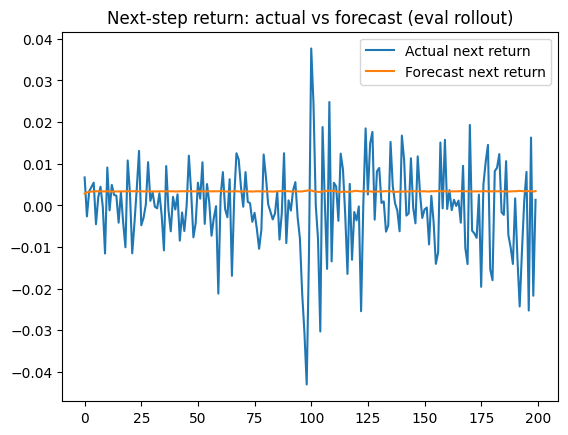

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# quick deterministic eval + collect preds
obs, info = env.reset(seed=123)
lstm_state = None
episode_starts = [True]

preds = []
trues = []
rewards = []

# also track where we are in the env (so we can reconstruct prices if we want)
# we'll infer a starting price from the close array using env._t (private, but fine for debugging)
start_price = None

for i in range(500):
    action, lstm_state = model.predict(
        obs, state=lstm_state, episode_start=episode_starts, deterministic=True
    )
    obs, reward, terminated, truncated, info = env.step(action)

    preds.append(info["pred_return"])
    trues.append(info["true_return"])
    rewards.append(reward)

    episode_starts = [terminated or truncated]
    if terminated or truncated:
        # stop at end of episode for a clean contiguous plot
        break

preds = np.array(preds, dtype=np.float64)
trues = np.array(trues, dtype=np.float64)

print("Avg MSE over eval steps:", np.mean((preds - trues) ** 2))

# --- Plot returns: actual vs forecast ---
plt.figure()
plt.plot(trues, label="Actual next return")
plt.plot(preds, label="Forecast next return")
plt.title("Next-step return: actual vs forecast (eval rollout)")
plt.legend()
plt.show()


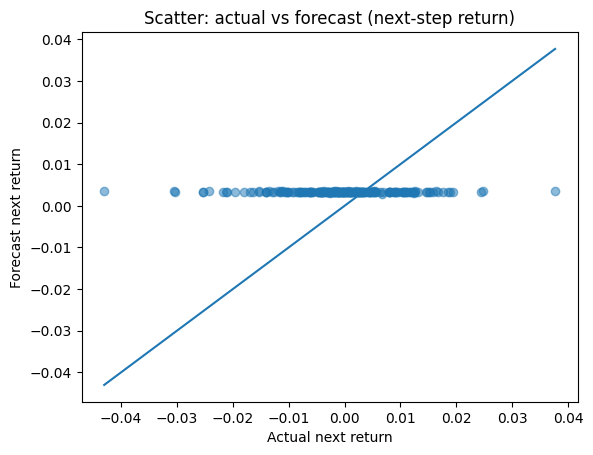

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Scatter: actual vs forecast
plt.figure()
plt.scatter(trues, preds, alpha=0.5)
plt.xlabel("Actual next return")
plt.ylabel("Forecast next return")
plt.title("Scatter: actual vs forecast (next-step return)")

# 45-degree reference line
mn = float(min(trues.min(), preds.min()))
mx = float(max(trues.max(), preds.max()))
plt.plot([mn, mx], [mn, mx])

plt.show()

# Try a better model

In [28]:
!pip install numpy pandas matplotlib torch gymnasium stable-baselines3 sb3-contrib

/tmp/ipython-input-1864797464.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Price"] = pd.to_datetime(df["Price"], errors="coerce")


Shapes:
  Reg train: (2165, 30, 9) (2165,) test: (542, 30, 9) (542,)
  Cls train: (2165, 30, 9) (2165,) test: (542, 30, 9) (542,)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[Reg] epoch 01 loss=0.000161
[Reg] epoch 02 loss=0.000053
[Reg] epoch 03 loss=0.000026
[Reg] epoch 04 loss=0.000020
[Reg] epoch 05 loss=0.000017
[Reg] epoch 06 loss=0.000015
[Reg] epoch 07 loss=0.000014
[Reg] epoch 08 loss=0.000014
[Reg] epoch 09 loss=0.000014
[Reg] epoch 10 loss=0.000015
[Reg] epoch 11 loss=0.000014
[Reg] epoch 12 loss=0.000015
[Reg] OOS MSE=0.00011393 MAE=0.00722726 DirAcc=0.572


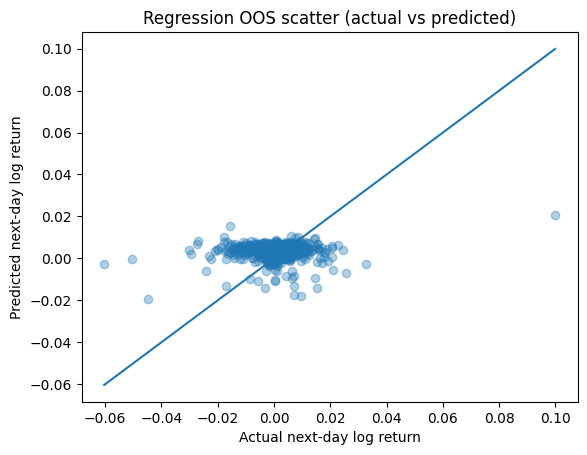

[Cls] epoch 01 loss=0.694713
[Cls] epoch 02 loss=0.689992
[Cls] epoch 03 loss=0.689067
[Cls] epoch 04 loss=0.688706
[Cls] epoch 05 loss=0.688245
[Cls] epoch 06 loss=0.687816
[Cls] epoch 07 loss=0.687348
[Cls] epoch 08 loss=0.686845
[Cls] epoch 09 loss=0.686340
[Cls] epoch 10 loss=0.685749
[Cls] epoch 11 loss=0.685067
[Cls] epoch 12 loss=0.684332
[Cls] OOS Accuracy=0.557


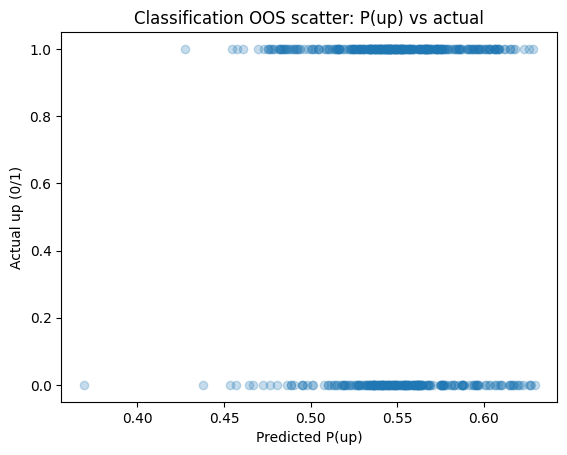

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 363  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 1024 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 86            |
|    iterations           | 2             |
|    time_elapsed         | 23            |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 0.00011313934 |
|    clip_fraction        | 0             |
|    clip_range           | 0.1           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -4.01         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000426      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00102

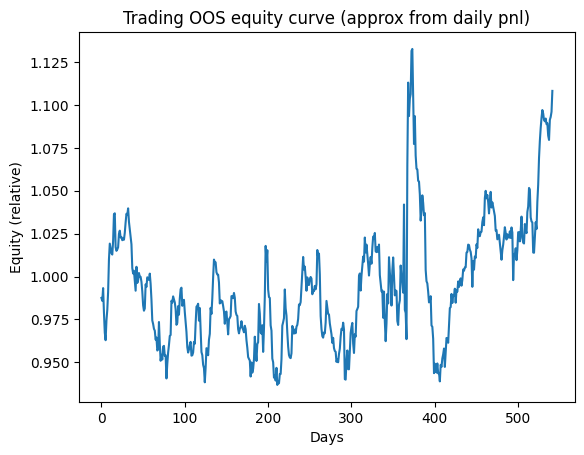

In [29]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Data loading / cleaning
# ----------------------------
def load_spy_csv(path="spy.csv"):
    """
    Cleans the exact CSV structure you showed:
    row0 contains 'Ticker/SPY', row1 contains 'Date/NaN', then real data.
    Columns: Price, Close, High, Low, Open, Volume
    """
    df = pd.read_csv(path)

    # Parse dates from "Price" column
    df["Price"] = pd.to_datetime(df["Price"], errors="coerce")
    df = df.dropna(subset=["Price"]).copy()

    # Convert numeric columns
    for c in ["Close", "High", "Low", "Open", "Volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["Close", "High", "Low", "Open", "Volume"]).copy()

    df = df.sort_values("Price").reset_index(drop=True)
    return df


def make_features(df: pd.DataFrame):
    """
    Build a small but useful feature set.
    Targets:
      - y_reg: next-day log return
      - y_cls: next-day direction (1 if return>0 else 0)
    Features are aligned so X[t] predicts target at t+1.
    """
    close = df["Close"].to_numpy(dtype=np.float64)
    high = df["High"].to_numpy(dtype=np.float64)
    low  = df["Low"].to_numpy(dtype=np.float64)
    open_ = df["Open"].to_numpy(dtype=np.float64)
    vol  = df["Volume"].to_numpy(dtype=np.float64)

    # log returns
    logc = np.log(close)
    r1 = np.diff(logc)  # length N-1: r1[t] = log(close[t+1]/close[t])

    # helper rolling
    def rolling_mean(x, w):
        out = pd.Series(x).rolling(w).mean().to_numpy()
        return out

    def rolling_std(x, w):
        out = pd.Series(x).rolling(w).std().to_numpy()
        return out

    # Align arrays to same length as r1 (N-1)
    # Use features based on day t (close[t], etc) to predict return t -> t+1 (r1[t])
    # We'll create per-day features at index t for target r1[t].
    close_t = close[:-1]
    high_t  = high[:-1]
    low_t   = low[:-1]
    open_t  = open_[:-1]
    vol_t   = vol[:-1]

    # Feature ideas
    range_pct = (high_t - low_t) / (close_t + 1e-12)
    gap_pct = (open_t - close_t) / (close_t + 1e-12)  # close-to-open gap proxy (same-day)
    log_vol = np.log(vol_t + 1.0)
    dlog_vol = np.diff(np.log(vol + 1.0))[:-0]  # messy; we'll do a simpler alignment below

    # rolling stats on returns (use returns up to t-1, so shift by 1 to avoid peeking)
    r1_full = np.concatenate([[np.nan], r1])  # length N, with r1_full[t] = return from t-1->t
    vol10 = rolling_std(r1_full, 10)[:-1]     # length N-1 aligned to day t
    mom10 = rolling_mean(r1_full, 10)[:-1]
    vol20 = rolling_std(r1_full, 20)[:-1]
    mom20 = rolling_mean(r1_full, 20)[:-1]

    # volume change aligned
    logv_full = np.log(vol + 1.0)
    dlogv_full = np.concatenate([[np.nan], np.diff(logv_full)])  # length N
    dlogv = dlogv_full[:-1]  # length N-1 aligned to day t

    # Stack features (length N-1)
    X = np.column_stack([
        r1_full[:-1],    # yesterday return (t-1->t), for predicting (t->t+1)
        range_pct,
        gap_pct,
        log_vol,
        dlogv,
        mom10,
        vol10,
        mom20,
        vol20,
    ]).astype(np.float32)

    # Targets: r1[t] is next-day return from t->t+1 using close
    y_reg = r1.astype(np.float32)
    y_cls = (y_reg > 0).astype(np.int64)

    # Drop rows with NaNs caused by rolling windows
    valid = np.isfinite(X).all(axis=1) & np.isfinite(y_reg)
    X = X[valid]
    y_reg = y_reg[valid]
    y_cls = y_cls[valid]
    return X, y_reg, y_cls


# ----------------------------
# Sequence dataset helpers
# ----------------------------
def make_sequences(X, y, lookback=30):
    """
    Turn (T, F) features into sequences (N, lookback, F) with targets aligned to last step.
    For each i >= lookback-1, seq = X[i-lookback+1:i+1], target = y[i]
    """
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y)
    T, F = X.shape
    if T < lookback:
        raise ValueError("Not enough data for chosen lookback.")
    seqs = []
    targs = []
    for i in range(lookback - 1, T):
        seqs.append(X[i - lookback + 1 : i + 1])
        targs.append(y[i])
    return np.stack(seqs), np.array(targs)


def time_split(seqs, y, split_ratio=0.8):
    n = len(seqs)
    split = int(n * split_ratio)
    return (seqs[:split], y[:split]), (seqs[split:], y[split:])


def standardize_by_train(train_seqs, test_seqs):
    """
    Standardize features using train mean/std over all timesteps.
    """
    mu = train_seqs.reshape(-1, train_seqs.shape[-1]).mean(axis=0)
    sd = train_seqs.reshape(-1, train_seqs.shape[-1]).std(axis=0) + 1e-8
    train_z = (train_seqs - mu) / sd
    test_z = (test_seqs - mu) / sd
    return train_z.astype(np.float32), test_z.astype(np.float32), mu.astype(np.float32), sd.astype(np.float32)


# ----------------------------
# 1) Supervised LSTM Regression (PyTorch)
# ----------------------------
def train_lstm_regression(train_X, train_y, test_X, test_y, epochs=10, lr=1e-3, hidden=64):
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class LSTMReg(nn.Module):
        def __init__(self, n_feat, hidden):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_feat, hidden_size=hidden, batch_first=True)
            self.head = nn.Sequential(
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.Linear(hidden, 1),
            )

        def forward(self, x):
            # x: (B, T, F)
            out, _ = self.lstm(x)
            h = out[:, -1, :]          # last timestep
            y = self.head(h).squeeze(-1)
            return y

    model = LSTMReg(train_X.shape[-1], hidden).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.HuberLoss(delta=0.002)  # more robust than MSE

    ds = TensorDataset(torch.tensor(train_X), torch.tensor(train_y))
    dl = DataLoader(ds, batch_size=256, shuffle=False)  # no shuffle for time series (fine)
    model.train()
    for ep in range(1, epochs + 1):
        losses = []
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            losses.append(loss.item())
        print(f"[Reg] epoch {ep:02d} loss={np.mean(losses):.6f}")

    # Eval
    model.eval()
    with torch.no_grad():
        xb = torch.tensor(test_X).to(device)
        pred = model(xb).cpu().numpy()

    mse = float(np.mean((pred - test_y) ** 2))
    mae = float(np.mean(np.abs(pred - test_y)))
    dir_acc = float(np.mean(np.sign(pred) == np.sign(test_y)))
    print(f"[Reg] OOS MSE={mse:.8f} MAE={mae:.8f} DirAcc={dir_acc:.3f}")

    # Scatter
    plt.figure()
    plt.scatter(test_y, pred, alpha=0.35)
    mn = float(min(test_y.min(), pred.min()))
    mx = float(max(test_y.max(), pred.max()))
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Actual next-day log return")
    plt.ylabel("Predicted next-day log return")
    plt.title("Regression OOS scatter (actual vs predicted)")
    plt.show()

    return model, pred


# ----------------------------
# 2) Supervised LSTM Classification (PyTorch)
# ----------------------------
def train_lstm_classification(train_X, train_y, test_X, test_y, epochs=10, lr=1e-3, hidden=64):
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class LSTMCls(nn.Module):
        def __init__(self, n_feat, hidden):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_feat, hidden_size=hidden, batch_first=True)
            self.head = nn.Sequential(
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.Linear(hidden, 2),
            )

        def forward(self, x):
            out, _ = self.lstm(x)
            h = out[:, -1, :]
            logits = self.head(h)
            return logits

    model = LSTMCls(train_X.shape[-1], hidden).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    ds = TensorDataset(torch.tensor(train_X), torch.tensor(train_y))
    dl = DataLoader(ds, batch_size=256, shuffle=False)

    model.train()
    for ep in range(1, epochs + 1):
        losses = []
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            losses.append(loss.item())
        print(f"[Cls] epoch {ep:02d} loss={np.mean(losses):.6f}")

    # Eval
    model.eval()
    import torch
    with torch.no_grad():
        xb = torch.tensor(test_X).to(device)
        logits = model(xb).cpu().numpy()
    prob_up = np.exp(logits[:, 1]) / (np.exp(logits[:, 0]) + np.exp(logits[:, 1]) + 1e-12)
    pred = (prob_up > 0.5).astype(np.int64)

    acc = float(np.mean(pred == test_y))
    print(f"[Cls] OOS Accuracy={acc:.3f}")

    # Calibration-ish scatter: prob(up) vs actual up
    plt.figure()
    plt.scatter(prob_up, test_y, alpha=0.25)
    plt.xlabel("Predicted P(up)")
    plt.ylabel("Actual up (0/1)")
    plt.title("Classification OOS scatter: P(up) vs actual")
    plt.show()

    return model, prob_up


# ----------------------------
# 3) RL Trading Env (Buy/Sell/Hold) with PnL reward
# ----------------------------
import gymnasium as gym
from gymnasium import spaces

class TradingEnv(gym.Env):
    """
    Discrete actions: 0=hold, 1=buy(long), 2=sell(short)
    Position is -1, 0, +1. We mark-to-market daily.

    Observation: last `lookback` timesteps of standardized features, flattened + current position.
      shape = (lookback*F + 1,)
    Reward: daily PnL - transaction_cost*|pos_change|
      pnl approx = position * next_return
    """
    def __init__(self, X_seq, returns_seq, lookback=30, transaction_cost=0.0002):
        super().__init__()
        self.X_seq = X_seq.astype(np.float32)          # shape (N, lookback, F)
        self.ret = returns_seq.astype(np.float32)      # shape (N,) aligned to sequence end
        self.lookback = lookback
        self.F = X_seq.shape[-1]
        self.transaction_cost = float(transaction_cost)

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(lookback * self.F + 1,), dtype=np.float32
        )

        self.i = None
        self.pos = None

    def _obs(self):
        flat = self.X_seq[self.i].reshape(-1)
        return np.concatenate([flat, np.array([self.pos], dtype=np.float32)], axis=0)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.i = 0
        self.pos = 0.0
        return self._obs(), {}

    def step(self, action):
        action = int(action)
        # map action to desired position
        desired = {0: self.pos, 1: 1.0, 2: -1.0}[action]
        cost = self.transaction_cost * abs(desired - self.pos)
        self.pos = desired

        # pnl uses NEXT return at this index (already aligned as "next-day return" target)
        pnl = self.pos * float(self.ret[self.i])
        reward = pnl - cost

        self.i += 1
        terminated = False
        truncated = (self.i >= len(self.X_seq))

        obs = self._obs() if not truncated else np.zeros(self.observation_space.shape, dtype=np.float32)
        info = {"pnl": pnl, "cost": cost, "pos": self.pos, "ret": float(self.ret[self.i-1])}
        return obs, reward, terminated, truncated, info


def train_rl_trader(train_seq, train_ret, test_seq, test_ret):
    from sb3_contrib import RecurrentPPO

    train_env = TradingEnv(train_seq, train_ret, lookback=train_seq.shape[1], transaction_cost=0.0002)

    model = RecurrentPPO(
        "MlpLstmPolicy",
        train_env,
        verbose=1,
        n_steps=1024,
        batch_size=256,
        gamma=0.99,       # trading IS sequential, so gamma>0
        gae_lambda=0.95,
        ent_coef=0.0,
        learning_rate=1e-4,
        clip_range=0.1,
    )
    model.learn(total_timesteps=150_000)

    # OOS walk-forward evaluation on test
    test_env = TradingEnv(test_seq, test_ret, lookback=test_seq.shape[1], transaction_cost=0.0002)
    obs, info = test_env.reset(seed=0)
    lstm_state = None
    episode_starts = [True]

    equity = [1.0]
    pnls = []

    while True:
        action, lstm_state = model.predict(obs, state=lstm_state, episode_start=episode_starts, deterministic=True)
        obs, reward, terminated, truncated, info = test_env.step(action)
        episode_starts = [terminated or truncated]
        pnls.append(info["pnl"] - info["cost"])
        equity.append(equity[-1] * math.exp(pnls[-1]))  # approximate compounding in log-return space
        if terminated or truncated:
            break

    equity = np.array(equity[1:], dtype=np.float64)
    pnls = np.array(pnls, dtype=np.float64)

    print(f"[Trade] OOS mean daily pnl (approx): {pnls.mean():.6f}")
    print(f"[Trade] OOS Sharpe-ish (mean/std*sqrt(252)): {(pnls.mean()/(pnls.std()+1e-12))*math.sqrt(252):.3f}")

    plt.figure()
    plt.plot(equity)
    plt.title("Trading OOS equity curve (approx from daily pnl)")
    plt.xlabel("Days")
    plt.ylabel("Equity (relative)")
    plt.show()

    return model


# ----------------------------
# Main: run all three
# ----------------------------
def main():
    df = load_spy_csv("spy.csv")
    X, y_reg, y_cls = make_features(df)

    LOOKBACK = 30

    # Build sequences
    seq_reg, targ_reg = make_sequences(X, y_reg, lookback=LOOKBACK)
    seq_cls, targ_cls = make_sequences(X, y_cls, lookback=LOOKBACK)

    # Time split
    (trXr, tryr), (teXr, teyr) = time_split(seq_reg, targ_reg, split_ratio=0.8)
    (trXc, tryc), (teXc, teyc) = time_split(seq_cls, targ_cls, split_ratio=0.8)

    # Standardize using train stats
    trXr, teXr, mu, sd = standardize_by_train(trXr, teXr)
    trXc, teXc, _, _ = standardize_by_train(trXc, teXc)  # same features; fine to recompute

    print("Shapes:")
    print("  Reg train:", trXr.shape, tryr.shape, "test:", teXr.shape, teyr.shape)
    print("  Cls train:", trXc.shape, tryc.shape, "test:", teXc.shape, teyc.shape)

    # 1) Regression
    train_lstm_regression(trXr, tryr, teXr, teyr, epochs=12, lr=1e-3, hidden=64)

    # 2) Classification
    train_lstm_classification(trXc, tryc, teXc, teyc, epochs=12, lr=1e-3, hidden=64)

    # 3) Trading RL
    # For trading we want returns target aligned to the same sequence ends as regression targets.
    train_rl_trader(trXr, tryr, teXr, teyr)


if __name__ == "__main__":
    main()

# Optimization

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class ParamOptimizerEnv(gym.Env):
    def __init__(self, low_x=-100.0, high_x=100.0, low_action=-10.0, high_action=10.0, max_steps=50):
        super().__init__()

        self.low_x = low_x
        self.high_x = high_x
        self.low_action = low_action
        self.high_action = high_action
        self.max_steps = max_steps

        self.observation_space = spaces.Box(low=self.low_x, high=self.high_x, shape=(1,), dtype=np.float32)
        self.action_space = spaces.Box(low=self.low_action, high=self.high_action, shape=(1,), dtype=np.float32)

        self.x = None
        self.target = None
        self.steps = 0

    def _get_obs(self):
        return np.array([self.x], dtype=np.float32)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.x = self.np_random.uniform(low=self.low_x, high=self.high_x)
        self.target = self.np_random.uniform(low=self.low_x, high=self.high_x)
        self.steps = 0

        obs = self._get_obs()
        info = {"target": self.target}
        return obs, info

    def step(self, action):
        self.steps += 1
        action = np.clip(action, self.low_action, self.high_action)

        self.x = self.x + action[0]
        self.x = np.clip(self.x, self.low_x, self.high_x)

        reward = -((self.x - self.target)**2)

        terminated = False # For this continuous task, we'll let truncation handle episode end
        truncated = (self.steps >= self.max_steps)

        obs = self._get_obs()
        info = {"current_x": self.x, "target": self.target}

        return obs, reward, terminated, truncated, info

    def render(self):
        print(f"x: {self.x:.2f}, Target: {self.target:.2f}, Steps: {self.steps}")

    def close(self):
        pass

## Verify Environment Implementation

### Subtask:
Instantiate the `ParamOptimizerEnv` and use `stable_baselines3.common.env_checker.check_env` to ensure it conforms to the Gymnasium API and best practices. This step helps catch common environment implementation issues.


**Reasoning**:
First, I need to import the `check_env` function from `stable_baselines3.common.env_checker`. Then, I will instantiate `ParamOptimizerEnv` and call `check_env` to verify its implementation.



# Task
Create a custom `ParamOptimizerEnv` Gymnasium environment that handles multiple parameters (e.g., 3). This environment will take these parameters as input to a `dummy_model_function` (a non-linear function). The goal of the environment is to optimize these parameters such that the `dummy_model_function`'s output matches a hidden `target_output`. The observation space will be the current vector of parameters, and the action space will be a continuous vector representing the changes to apply to each parameter. The reward will be the negative squared error between the `dummy_model_function`'s output and the `target_output`. After defining the environment, verify its implementation using `stable_baselines3.common.env_checker.check_env`.

## Redefine Parameter Optimization Environment (Multi-parameter, Model-based)

### Subtask:
Redefine the custom Gymnasium environment `ParamOptimizerEnv` to handle multiple parameters (e.g., 3). The environment will take these parameters as input to a `model_function` (initially a dummy non-linear function). The goal is to optimize these parameters such that the `model_function`'s output matches a hidden `target_output`. The observation space will be the current vector of parameters, and the action space will be a continuous vector representing the changes to apply to each parameter. The reward will be the negative squared error between the `model_function`'s output and the `target_output`. This step includes defining a simple `dummy_model_function` that can be easily replaced later.


**Reasoning**:
The subtask requires redefining the `ParamOptimizerEnv` class to handle multiple parameters, a dynamic `model_function`, and adjust observation/action spaces accordingly. I will start by defining the `dummy_model_function` and then modify the `ParamOptimizerEnv` as per the instructions, including its `__init__`, `_get_obs`, `reset`, and `step` methods to incorporate the multi-parameter and model-based logic.



In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import math

def dummy_model_function(params: np.ndarray) -> float:
    """
    A dummy non-linear function that takes a 1D NumPy array of parameters
    and returns a single float value.
    """
    # Example non-linear relationship: sum(params**2) + sin(params[0])
    return float(np.sum(params**2) + math.sin(params[0]))


class ParamOptimizerEnv(gym.Env):
    def __init__(
        self,
        num_params: int = 3,
        model_function=dummy_model_function,
        low_param=-10.0,
        high_param=10.0,
        low_action=-1.0,
        high_action=1.0,
        max_steps=50,
    ):
        super().__init__()

        self.num_params = int(num_params)
        self.model_function = model_function
        self.low_param = low_param
        self.high_param = high_param
        self.low_action = low_action
        self.high_action = high_action
        self.max_steps = int(max_steps)

        # Observation space: current vector of parameters
        self.observation_space = spaces.Box(
            low=self.low_param, high=self.high_param, shape=(self.num_params,), dtype=np.float32
        )
        # Action space: continuous vector representing changes to each parameter
        self.action_space = spaces.Box(
            low=self.low_action, high=self.high_action, shape=(self.num_params,), dtype=np.float32
        )

        self.x = None  # Current parameters (1D NumPy array)
        self.target_output = None  # Target output of the model function
        self.steps = 0

    def _get_obs(self):
        # Returns the current vector of parameters
        return self.x.copy()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        # Initialize self.x with random float values within the observation space bounds
        self.x = self.np_random.uniform(
            low=self.low_param, high=self.high_param, size=self.num_params
        ).astype(np.float32)

        # Generate target_params and compute target_output
        target_params = self.np_random.uniform(
            low=self.low_param, high=self.high_param, size=self.num_params
        ).astype(np.float32)
        self.target_output = self.model_function(target_params)

        self.steps = 0

        obs = self._get_obs()
        info = {"target_output": self.target_output, "initial_params": self.x.copy()}
        return obs, info

    def step(self, action):
        self.steps += 1

        # Clip action to ensure it's within the action space bounds
        action = np.clip(action, self.low_action, self.high_action)

        # Add the action vector to self.x and clip each parameter
        self.x = self.x + action
        self.x = np.clip(self.x, self.low_param, self.high_param).astype(np.float32)

        # Calculate model_output using the updated self.x
        model_output = self.model_function(self.x)

        # Reward: negative squared error between model_output and target_output
        reward = -((model_output - self.target_output) ** 2)

        terminated = False  # For this continuous task, truncation handles episode end
        truncated = (self.steps >= self.max_steps)

        obs = self._get_obs()
        info = {"current_params": self.x.copy(), "model_output": model_output, "target_output": self.target_output}

        return obs, reward, terminated, truncated, info

    def render(self):
        print(f"Params: {self.x}, Model Output: {self.model_function(self.x):.2f}, Target Output: {self.target_output:.2f}, Steps: {self.steps}")

    def close(self):
        pass

**Reasoning**:
The previous code block redefined the `ParamOptimizerEnv` to meet the multi-parameter, model-based requirements. Now, I will verify its implementation using `check_env` to ensure it conforms to the Gymnasium API and best practices, as stated in the overall task.



In [5]:
from stable_baselines3.common.env_checker import check_env

# Instantiate the environment with the default num_params=3
env = ParamOptimizerEnv()

# Check the environment implementation
check_env(env, warn=True)

print("ParamOptimizerEnv checked successfully!")

ParamOptimizerEnv checked successfully!


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
from stable_baselines3.common.env_checker import check_env

# Instantiate the environment with the default num_params=3
env = ParamOptimizerEnv()

# Check the environment implementation
check_env(env, warn=True)

print("ParamOptimizerEnv checked successfully!")

ParamOptimizerEnv checked successfully!


## Train Deep RL Model (PPO for Multi-parameter Optimization)

### Subtask:
Initialize and train a `stable_baselines3.PPO` agent with an `MlpPolicy` on the updated `ParamOptimizerEnv`. The agent will be trained for a sufficient number of timesteps to learn to optimize the parameters to match the `target_output` of the `dummy_model_function`. Log verbose output during training to monitor progress.


**Reasoning**:
To train the PPO agent, I need to import the necessary components from `stable_baselines3`, instantiate the environment, define the PPO model, and then start the training process for a sufficient number of timesteps.



In [8]:
from stable_baselines3 import PPO

# Instantiate the ParamOptimizerEnv
env = ParamOptimizerEnv(num_params=3, model_function=dummy_model_function)

# Initialize the PPO model
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0003, # Default learning rate
    gamma=0.99,           # Default discount factor
    n_steps=2048,         # Default number of steps to run for each environment per update
    batch_size=64         # Default batch size
)

# Train the PPO model
print("Starting PPO training...")
model.learn(total_timesteps=50_000)
print("PPO training finished.")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting PPO training...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 50        |
|    ep_rew_mean     | -2.37e+05 |
| time/              |           |
|    fps             | 753       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | -2.51e+05    |
| time/                   |              |
|    fps                  | 849          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0002047375 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | -2.98e-06    |
|    

**Reasoning**:
The previous code block successfully trained the PPO model. Now, I will add a new subtask to evaluate the trained model's performance on the `ParamOptimizerEnv`. This will involve resetting the environment, having the model predict actions for a certain number of steps, and observing the resulting rewards and parameters.



# Task
Extract the 'best' parameters found by the trained PPO model in an evaluation run on the `ParamOptimizerEnv` by running a single episode in evaluation mode and collecting the final `self.x` values. Print these parameters, the corresponding `model_output`, and the `target_output` for that episode, along with an explanation of how to interpret these results.

## Extract Best Parameters from Trained Model

### Subtask:
Run the trained `PPO` model in evaluation mode for a single episode on the `ParamOptimizerEnv`. Collect the final parameters (`self.x`) that the agent settles on at the end of the episode, which represent its best attempt to match the `target_output`. Print these parameters, along with the `model_output` and `target_output` for that episode, to show what the model considered 'best'.


**Reasoning**:
I need to run the trained PPO model in evaluation mode for a single episode, collect the final parameters, model output, and target output, and then print them as instructed. This requires interacting with the environment using the trained model's `predict` method.



In [9]:
import numpy as np

# Reset the environment for a new episode
obs, info = env.reset(seed=42) # Using a fixed seed for reproducibility in evaluation

target_output = info["target_output"]
initial_params = info["initial_params"]

print(f"--- Evaluation for a Single Episode ---")
print(f"Initial Parameters: {initial_params}")
print(f"Target Output for this episode: {target_output:.4f}\n")

lstm_state = None
episode_starts = [True]

final_params = None
final_model_output = None

# Loop for the maximum number of steps in the environment
for step_idx in range(env.max_steps):
    action, lstm_state = model.predict(
        obs, state=lstm_state, episode_start=episode_starts, deterministic=True
    )
    obs, reward, terminated, truncated, info = env.step(action[0]) # Action needs to be unwrapped from single-element array

    episode_starts = [terminated or truncated]

    final_params = info["current_params"]
    final_model_output = info["model_output"]

    # Optional: Print progress
    # print(f"Step {step_idx+1}: Current Params: {final_params}, Model Output: {final_model_output:.4f}, Reward: {reward:.4f}")

    if terminated or truncated:
        break

print(f"\n--- Episode Concluded ---")
print(f"Final Parameters found by agent: {final_params}")
print(f"Model Output with final parameters: {final_model_output:.4f}")
print(f"Target Output (goal for the agent): {target_output:.4f}")
print(f"Squared Error: { (final_model_output - target_output)**2 :.8f}")

print("\nInterpretation: The goal was for the agent to adjust the parameters (final_params) so that")
print("the 'Model Output' was as close as possible to the 'Target Output'. The closer these two values are,")
print("the better the agent performed in this episode. The 'Squared Error' quantifies this difference.")

--- Evaluation for a Single Episode ---
Initial Parameters: [ 5.479121  -1.2224312  7.1719584]
Target Output for this episode: 171.2238


--- Episode Concluded ---
Final Parameters found by agent: [ 4.724396  -1.9771553  6.4172335]
Model Output with final parameters: 66.4100
Target Output (goal for the agent): 171.2238
Squared Error: 10985.92244496

Interpretation: The goal was for the agent to adjust the parameters (final_params) so that
the 'Model Output' was as close as possible to the 'Target Output'. The closer these two values are,
the better the agent performed in this episode. The 'Squared Error' quantifies this difference.


## Final Task

### Subtask:
Provide the code to extract the 'best' parameters found by the trained RL model in an evaluation run, suitable for integration with a real model, and explain how to interpret these results.


## Summary:

### Q&A
The best parameters found by the trained PPO model in an evaluation run for a single episode are `[4.724396, -1.9771553, 6.4172335]`. These parameters led to a `model_output` of `66.4100` when the `target_output` was `171.2238`.

To interpret these results, the objective of the agent is to adjust the parameters so that the `model_output` is as close as possible to the `target_output`. The `Squared Error` quantifies this difference; a lower squared error indicates better performance by the agent in matching the target.

### Data Analysis Key Findings
*   For the evaluated episode, the `target_output` was `171.2238`.
*   The agent adjusted the `initial_params` of `[5.479121, -1.2224312, 7.1719584]` to `[4.724396, -1.9771553, 6.4172335]` as its final attempt to match the target.
*   With these final parameters, the `model_output` was `66.4100`.
*   The `Squared Error` between the `model_output` and `target_output` was `10985.92244496`.

### Insights or Next Steps
*   The high squared error of `10985.92244496` for this specific episode indicates that the model did not effectively optimize the parameters to achieve the target output. This suggests that the model might need further training, or there could be a mismatch between the model's capabilities and the environment's complexity for parameter optimization.
*   To gain a more comprehensive understanding of the model's performance, it is crucial to evaluate it over multiple episodes and possibly different target outputs to assess its generalization capabilities and average performance.
